In [1]:
%%file sales.py

import csv
import json
import sys
from datetime import datetime
from time import sleep

from kafka import KafkaProducer

if __name__ == "__main__":
    SERVER = "broker:9092"

    producer = KafkaProducer(
        bootstrap_servers=[SERVER],
        value_serializer=lambda x: json.dumps(x).encode("utf-8"),
        api_version=(2, 7, 0),
    )

    csv_file = "Sales_Data.csv"  # Path to our CSV file

    try:
        with open(csv_file, "r") as file:
            reader = csv.DictReader(file)
            for row in reader:
                message = {
                    "time": str(datetime.now()),
                    **row  # Assuming CSV headers match Kafka message attributes
                }

    
                producer.send("sales", value=message)
                sleep(1)
    except KeyboardInterrupt:
        producer.close()


Overwriting sales.py


In [2]:
import os
import pandas as pd
import numpy as np

In [3]:
all_data = pd.read_csv("Sales_Data.csv")
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
1,NaN,NaN,NaN,NaN,NaN,NaN
2,176559,Bose SoundSport Headphones,1,99.99,04-07-2019 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04-12-2019 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04-12-2019 14:38,"669 Spruce St, Los Angeles, CA 90001"


Clean up the data!

The first step in this is figuring out what we need to clean. I have found in practice, that you find things you need to clean as you perform operations and get errors. Based on the error, you decide how you should go about cleaning the data

Drop rows of NAN

In [4]:
# Find NAN
nan_df = all_data[all_data.isna().any(axis=1)]
display(nan_df.head())

all_data = all_data.dropna(how='all')
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
1,NaN,NaN,NaN,NaN,NaN,NaN
356,NaN,NaN,NaN,NaN,NaN,NaN
735,NaN,NaN,NaN,NaN,NaN,NaN
1433,NaN,NaN,NaN,NaN,NaN,NaN
1553,NaN,NaN,NaN,NaN,NaN,NaN


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
2,176559,Bose SoundSport Headphones,1,99.99,04-07-2019 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04-12-2019 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04-12-2019 14:38,"669 Spruce St, Los Angeles, CA 90001"
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001"


Get rid of text in order date column

In [5]:
all_data = all_data[all_data['Order Date'].str[0:2]!='Or']

Make columns correct type

In [6]:
all_data['Quantity Ordered'] = pd.to_numeric(all_data['Quantity Ordered'])
all_data['Price Each'] = pd.to_numeric(all_data['Price Each'])

Augment data with additional columns

Add month column

In [7]:
all_data['Month'] = all_data['Order Date'].str[0:2]
all_data['Month'] = all_data['Month'].astype('int32')
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001",4
2,176559,Bose SoundSport Headphones,1,99.99,04-07-2019 22:30,"682 Chestnut St, Boston, MA 02215",4
3,176560,Google Phone,1,600.00,04-12-2019 14:38,"669 Spruce St, Los Angeles, CA 90001",4
4,176560,Wired Headphones,1,11.99,04-12-2019 14:38,"669 Spruce St, Los Angeles, CA 90001",4
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001",4


Add month column (alternative method)

In [8]:
all_data['Month 2'] = pd.to_datetime(all_data['Order Date']).dt.month
all_data.head()

/tmp/ipykernel_788/1522122304.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  all_data['Month 2'] = pd.to_datetime(all_data['Order Date']).dt.month


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,Month 2
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001",4,4
2,176559,Bose SoundSport Headphones,1,99.99,04-07-2019 22:30,"682 Chestnut St, Boston, MA 02215",4,4
3,176560,Google Phone,1,600.00,04-12-2019 14:38,"669 Spruce St, Los Angeles, CA 90001",4,4
4,176560,Wired Headphones,1,11.99,04-12-2019 14:38,"669 Spruce St, Los Angeles, CA 90001",4,4
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001",4,4


Add city column

In [9]:
def get_city(address):
    return address.split(",")[1].strip(" ")

def get_state(address):
    return address.split(",")[2].split(" ")[1]

all_data['City'] = all_data['Purchase Address'].apply(lambda x: f"{get_city(x)}  ({get_state(x)})")
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,Month 2,City
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001",4,4,Dallas (TX)
2,176559,Bose SoundSport Headphones,1,99.99,04-07-2019 22:30,"682 Chestnut St, Boston, MA 02215",4,4,Boston (MA)
3,176560,Google Phone,1,600.00,04-12-2019 14:38,"669 Spruce St, Los Angeles, CA 90001",4,4,Los Angeles (CA)
4,176560,Wired Headphones,1,11.99,04-12-2019 14:38,"669 Spruce St, Los Angeles, CA 90001",4,4,Los Angeles (CA)
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001",4,4,Los Angeles (CA)


Data Exploration!

In [10]:
product_revenue = all_data.groupby('Product')['Price Each'].sum()
top_5_products = product_revenue.nlargest(5)

# Display the top 5 products with the highest revenue
for product, revenue in top_5_products.items():
    print(product, revenue)

Macbook Pro Laptop 8030800.0
iPhone 4789400.0
ThinkPad Laptop 4127958.72
Google Phone 3315000.0
27in 4K Gaming Monitor 2429637.7


In [11]:
df = all_data[all_data['Order ID'].duplicated(keep=False)]

df['Grouped'] = df.groupby('Order ID')['Product'].transform(lambda x: ','.join(x))
df2 = df[['Order ID', 'Grouped']].drop_duplicates()

/tmp/ipykernel_788/3593477360.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Grouped'] = df.groupby('Order ID')['Product'].transform(lambda x: ','.join(x))


In [12]:
from itertools import combinations
from collections import Counter

count = Counter()

for row in df2['Grouped']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 2)))

for key,value in count.most_common(10):
    print(key, value)

('iPhone', 'Lightning Charging Cable') 1005
('Google Phone', 'USB-C Charging Cable') 987
('iPhone', 'Wired Headphones') 447
('Google Phone', 'Wired Headphones') 414
('Vareebadd Phone', 'USB-C Charging Cable') 361
('iPhone', 'Apple Airpods Headphones') 360
('Google Phone', 'Bose SoundSport Headphones') 220
('USB-C Charging Cable', 'Wired Headphones') 160
('Vareebadd Phone', 'Wired Headphones') 143
('Lightning Charging Cable', 'Wired Headphones') 92


In [17]:
# from collections import Counter

# product_quantity = Counter(all_data['Product'])

# top_selling_products = product_quantity.most_common(10)

# for product, quantity in top_selling_products:
#     print(product, quantity)


USB-C Charging Cable 21903
Lightning Charging Cable 21658
AAA Batteries (4-pack) 20641
AA Batteries (4-pack) 20577
Wired Headphones 18882
Apple Airpods Headphones 15549
Bose SoundSport Headphones 13325
27in FHD Monitor 7507
iPhone 6842
27in 4K Gaming Monitor 6230


What are the most profitable products?

In [20]:
from collections import Counter

product_sales = Counter()

for _, row in all_data.iterrows():
    product_sales[row['Product']] += row['Quantity Ordered'] * row['Price Each']

top_profitable_products = product_sales.most_common(10)

for product, sales in top_profitable_products:
    print(product, sales)



Macbook Pro Laptop 8037600.0
iPhone 4794300.0
ThinkPad Laptop 4129958.700000436
Google Phone 3319200.0
27in 4K Gaming Monitor 2435097.5600001453
34in Ultrawide Monitor 2355558.010000104
Apple Airpods Headphones 2349150.0
Flatscreen TV 1445700.0
Bose SoundSport Headphones 1345565.4299998903
27in FHD Monitor 1132424.49999994


What are the top-selling products in each month?

In [21]:
from collections import defaultdict

# Create a dictionary to store the total quantity sold for each product in each month
monthly_product_sales = defaultdict(Counter)

for _, row in all_data.iterrows():
    month = row['Month']
    product = row['Product']
    quantity_sold = row['Quantity Ordered']
    monthly_product_sales[month][product] += quantity_sold

# Iterate over each month and print the top-selling products
for month, product_sales in monthly_product_sales.items():
    print(f"Month {month} Top-Selling Products:")
    top_selling_products = product_sales.most_common(10)
    for product, quantity in top_selling_products:
        print(f"{product}: {quantity}")
    print()


Month 4 Top-Selling Products:
AAA Batteries (4-pack): 2939
AA Batteries (4-pack): 2821
Lightning Charging Cable: 2373
USB-C Charging Cable: 2269
Wired Headphones: 2065
Apple Airpods Headphones: 1519
Bose SoundSport Headphones: 1287
27in FHD Monitor: 736
iPhone: 693
34in Ultrawide Monitor: 654

Month 5 Top-Selling Products:
AAA Batteries (4-pack): 2927
AA Batteries (4-pack): 2384
Lightning Charging Cable: 2075
USB-C Charging Cable: 2068
Wired Headphones: 1876
Apple Airpods Headphones: 1365
Bose SoundSport Headphones: 1176
27in FHD Monitor: 689
iPhone: 640
34in Ultrawide Monitor: 544

Month 8 Top-Selling Products:
AAA Batteries (4-pack): 2021
AA Batteries (4-pack): 1828
USB-C Charging Cable: 1462
Lightning Charging Cable: 1443
Wired Headphones: 1291
Apple Airpods Headphones: 1009
Bose SoundSport Headphones: 881
27in FHD Monitor: 491
27in 4K Gaming Monitor: 440
iPhone: 439

Month 9 Top-Selling Products:
AAA Batteries (4-pack): 1923
AA Batteries (4-pack): 1771
USB-C Charging Cable: 1594
Li

What is the average price of products sold in each city?

In [22]:
average_price = all_data.groupby('City')['Price Each'].mean()

for city, price in average_price.items():
    print(f"The average price of products sold in {city} is: ${price:.2f}")



The average price of products sold in Atlanta  (GA) is: $186.81
The average price of products sold in Austin  (TX) is: $182.72
The average price of products sold in Boston  (MA) is: $182.47
The average price of products sold in Dallas  (TX) is: $185.74
The average price of products sold in Los Angeles  (CA) is: $183.13
The average price of products sold in New York City  (NY) is: $186.34
The average price of products sold in Portland  (ME) is: $182.15
The average price of products sold in Portland  (OR) is: $185.87
The average price of products sold in San Francisco  (CA) is: $183.57
The average price of products sold in Seattle  (WA) is: $185.53


What product sold the most? Why do you think it sold the most?

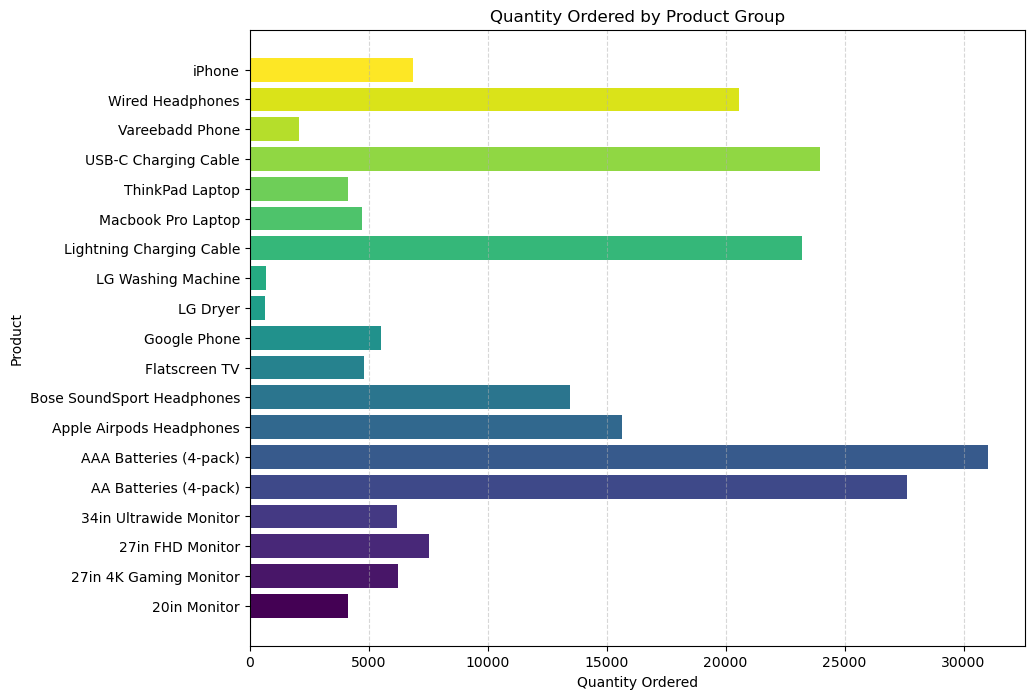

In [62]:
# product_group = all_data.groupby('Product')
# quantity_ordered = product_group.sum()['Quantity Ordered']
# keys = [pair for pair, df in product_group]

# fig, ax = plt.subplots(figsize=(10, 8))
# bar_colors = plt.cm.viridis(np.linspace(0, 1, len(keys)))
# ax.barh(keys, quantity_ordered, color=bar_colors)

# ax.set_xlabel('Quantity Ordered')
# ax.set_ylabel('Product')
# ax.set_title('Quantity Ordered by Product Group')

# ax.grid(True, axis='x', linestyle='--', alpha=0.5)

# plt.show()